# Install packages and download data

In [ ]:
pip install git+https://github.com/keras-team/keras-tuner.git

In [ ]:
pip install autokeras

In [ ]:
!wget ftp://ftp.nersc.no/pub/ml_course/data4cnn.npz

## Import libraries

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.util import view_as_windows

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense,
                                     Flatten,
                                     Dropout,
                                     BatchNormalization, 
                                     Conv2D, 
                                     MaxPooling2D)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

import autokeras as ak

# Load data and prepare for CNN

In [6]:
# Load 2D data with 2 bands from a SAR image and sea ice concentration
img_hh = np.load('data4cnn.npz')['img_hh']
img_hv = np.load('data4cnn.npz')['img_hv']
sic = np.load('data4cnn.npz')['sic']
print(img_hh.shape, img_hv.shape, sic.shape)

(2500, 2500) (2500, 2500) (500, 500)


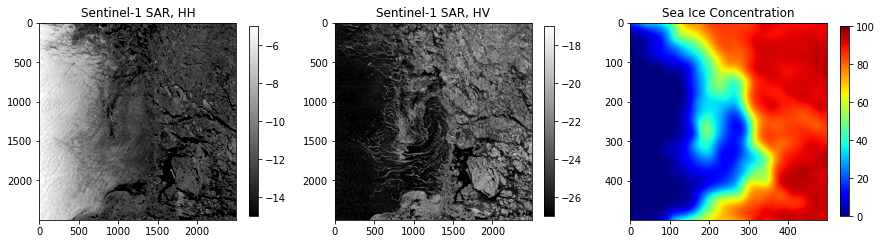

In [7]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
img0 = ax[0].imshow(img_hh.astype(float), clim=[-15, -5], cmap='gray')
img1 = ax[1].imshow(img_hv.astype(float), clim=[-27, -17], cmap='gray')
img2 = ax[2].imshow(sic, clim=[0,100], cmap='jet')

plt.colorbar(img0, ax=ax[0], shrink=0.7)
plt.colorbar(img1, ax=ax[1], shrink=0.7)
plt.colorbar(img2, ax=ax[2], shrink=0.7)

ax[0].set_title('Sentinel-1 SAR, HH')
ax[1].set_title('Sentinel-1 SAR, HV')
ax[2].set_title('Sea Ice Concentration')
plt.show()

In [17]:
# Create training input and output data

# Input: 
# Small patches from SAR images from two bands
# Shape: N x 25 x 25 x 2

# Output:
# Average concentration for a given patch
# Shape: N x 1

# Define size pf SAR image patch and step at which the patches are sampled
ws_sar = 25
stp_sar = 50
# Define size and step for SIC (input SIC image is 5 times smaller than SAR image)
ws_sic = int(ws_sar/5)
stp_sic = int(stp_sar/5)

# Create samples using view_as_windows
# Shape: number_of_windows_in_Y x number_of_windows_in_X x window_size_Y x window_size_X
hh = view_as_windows(img_hh, ws_sar, stp_sar)
hv = view_as_windows(img_hv, ws_sar, stp_sar)
ic = view_as_windows(sic, ws_sic, stp_sic)
print(hh.shape, ic.shape)

# Reshape into N x window_size_Y x window_size_X
hhr = hh.reshape(hh.shape[0]*hh.shape[1], ws_sar, ws_sar)
hvr = hv.reshape(hv.shape[0]*hv.shape[1], ws_sar, ws_sar)
icr = ic.reshape(hv.shape[0]*hv.shape[1], ws_sic, ws_sic)
print(hvr.shape, icr.shape)


(50, 50, 25, 25) (50, 50, 5, 5)
(2500, 25, 25) (2500, 5, 5)


In [18]:
# Find valid samples
# Finite values of SAR and valid values of SIC
valid = np.where(np.isfinite(hvr.min(axis=(1,2))) * (icr.min(axis=(1,2)) >= 0))[0]
print(valid.shape)

(2263,)


In [19]:
# Stack into shapes for CNN
# Input:
# N_samples x WIDTH x HEIGHT x BANDS
# Output:
# N_samples
x = np.stack([hvr, hhr], axis=3)[valid]
y = icr.mean(axis=(1,2))[valid]
print(x.shape, y.shape)

(2263, 25, 25, 2) (2263,)


# Train a simplest CNN

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 23, 23, 5)         95        
_________________________________________________________________
flatten_2 (Flatten)          (None, 2645)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 2646      
Total params: 2,741
Trainable params: 2,741
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
19/19 [==============================] - 1s 26ms/step - loss: 2583.5244 - val_loss: 1709.0852
Epoch 2/20
19/19 [==============================] - 0s 20ms/step - loss: 1296.3337 - val_loss: 1185.3687
Epoch 3/20
19/19 [==============================] - 0s 21ms/step - loss: 1175.7500 - val_loss: 1167.3292
Epoch 4/20
19/19 [==============================] - 0s 20ms/step - 

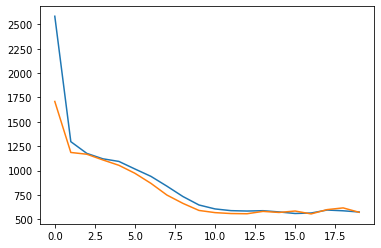

In [20]:
# Create a CNN with an simplest configuration
# Sequential type NN: one input + hidden layers + one output
m = Sequential()
# Convolutional layer. Input: SAR in HH and HV polarisations
m.add(Conv2D(
    filters=5, 
    kernel_size=(3,3), 
    strides=(1,1), 
    padding='valid', 
    activation='relu', 
    input_shape=x.shape[1:]))
# Reshape from 2D to 1D
m.add(Flatten())
# Output neuron with SIC
m.add(Dense(units=1, kernel_initializer='random_normal'))

# Plot summary
m.summary()

# Compile model and set how to compute LOSS and how to Optimize
m.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))

# Train model in 20 epochs with batch_size = 100. 20% of data go to validation
h1 = m.fit(x, y, batch_size=100, epochs=20, validation_split=0.2)

# Plot how eeror was decreasing with training
plt.plot(h1.history['loss'])
plt.plot(h1.history['val_loss'])
print('LOSS', h1.history['loss'][-1], h1.history['val_loss'][-1])    


# Apply the simplest CNN to the training data

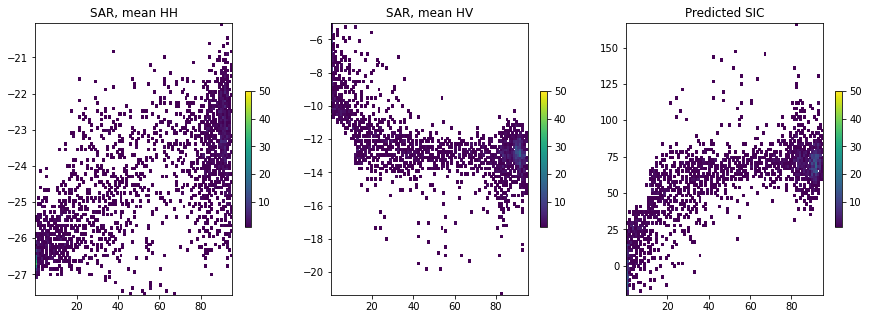

In [23]:
# predicted SIC
y_pred = m.predict(x).flatten()

# average over SAR sub-images
x_avg = x.mean(axis=(1,2))
avg_hh = x_avg[:,0]
avg_hv = x_avg[:,1]

fig, ax = plt.subplots(1, 3, figsize=(15,5))
im0 = ax[0].hist2d(y, avg_hh, 100, cmin=1, vmax=50)[3]
plt.colorbar(im0, ax=ax[0], shrink=0.5)
ax[0].set_title('SAR, mean HH')

im1 = ax[1].hist2d(y, avg_hv, 100, cmin=1, vmax=50)[3]
plt.colorbar(im1, ax=ax[1], shrink=0.5)
ax[1].set_title('SAR, mean HV')

im2 = ax[2].hist2d(y, y_pred, 100, cmin=1, vmax=50)[3]
plt.colorbar(im2, ax=ax[2], shrink=0.5)
ax[2].set_title('Predicted SIC')
plt.show()

# Apply the simplest CNN to all data and plot maps

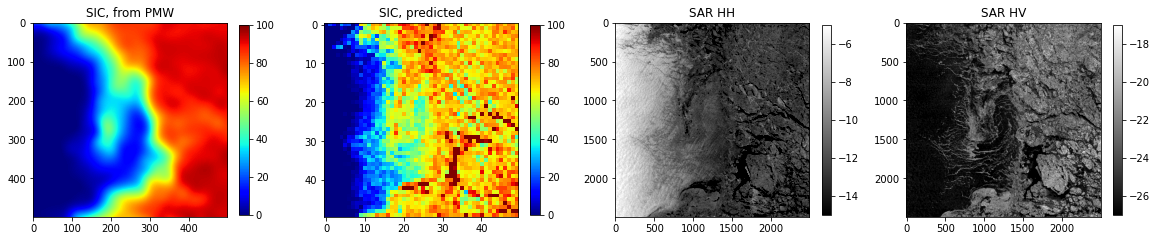

In [25]:
x_all = np.stack([hvr, hhr], axis=3)
y_all = m.predict(x_all)
y_all.shape = hv.shape[:2]

fig, ax = plt.subplots(1,4, figsize=(20,5))
img0 = ax[0].imshow(sic, clim=[0,100], cmap='jet')
ax[0].set_title('SIC, from PMW')
img1 = ax[1].imshow(y_all, clim=[0,100], cmap='jet')
ax[1].set_title('SIC, predicted')
img2 = ax[2].imshow(img_hh.astype(float), clim=[-15, -5], cmap='gray')
ax[2].set_title('SAR HH')
img3 = ax[3].imshow(img_hv.astype(float), clim=[-27, -17], cmap='gray')
ax[3].set_title('SAR HV')

for img, a in zip([img0, img1, img2, img3], ax):
  plt.colorbar(img, ax=a, shrink=0.7)

plt.show()

# Let's make more complicated architectures and test

In [63]:
# Several models are defined in dictionary mm
mm = {}

mm['cd'] = Sequential()
mm['cd'].add(Conv2D(5, 3, activation='relu', input_shape=x.shape[1:]))
mm['cd'].add(Flatten())
mm['cd'].add(Dense(1, kernel_initializer='random_normal'))

mm['cpd'] = Sequential()
mm['cpd'].add(Conv2D(5, 3, activation='relu', input_shape=x.shape[1:]))
mm['cpd'].add(MaxPooling2D(2, 2))
mm['cpd'].add(Flatten())
mm['cpd'].add(Dense(1, kernel_initializer='random_normal'))

mm['cpdd'] = Sequential()
mm['cpdd'].add(Conv2D(5, 3, activation='relu', input_shape=x.shape[1:]))
mm['cpdd'].add(MaxPooling2D(2, 2))
mm['cpdd'].add(Flatten())
mm['cpdd'].add(Dense(10))
mm['cpdd'].add(Dense(1, kernel_initializer='random_normal'))

mm['ccpdd'] = Sequential()
mm['ccpdd'].add(Conv2D(5, 3, activation='relu', input_shape=x.shape[1:]))
mm['ccpdd'].add(Conv2D(5, 3, activation='relu'))
mm['ccpdd'].add(MaxPooling2D(2, 2))
mm['ccpdd'].add(Flatten())
mm['ccpdd'].add(Dense(10))
mm['ccpdd'].add(Dense(1, kernel_initializer='random_normal'))

mm['ccpccpdd'] = Sequential()
mm['ccpccpdd'].add(Conv2D(5, 3, activation='relu', input_shape=x.shape[1:]))
mm['ccpccpdd'].add(Conv2D(5, 3, activation='relu'))
mm['ccpccpdd'].add(MaxPooling2D(2, 2))
mm['ccpccpdd'].add(Conv2D(10, 3, activation='relu'))
mm['ccpccpdd'].add(Conv2D(10, 3, activation='relu'))
mm['ccpccpdd'].add(MaxPooling2D(2, 2))
mm['ccpccpdd'].add(Flatten())
mm['ccpccpdd'].add(Dense(10))
mm['ccpccpdd'].add(Dense(1, kernel_initializer='random_normal'))

def compile_fit(m, epochs=15):
    """ Compile and train the model. Print accuracy and summary. 
    Inputs
    ------
    m : Sequential model
    epochs: int

    Returns
    -------
    h : history of training
    """
    m.compile(loss='mean_squared_error', optimizer=Adam())
    h = m.fit(x, y, batch_size=100, epochs=epochs, validation_split=0.2, verbose=False)
    print(h.history['loss'][-1], h.history['val_loss'][-1])    
    m.summary()
    print('\n\n')
    return h


# Train all the models


In [64]:
# Keep histories in dictionary hh 
hh = {name: compile_fit(mm[name]) for name in mm}

1028.313720703125 984.588623046875
Model: "sequential_80"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_149 (Conv2D)          (None, 23, 23, 5)         95        
_________________________________________________________________
flatten_80 (Flatten)         (None, 2645)              0         
_________________________________________________________________
dense_132 (Dense)            (None, 1)                 2646      
Total params: 2,741
Trainable params: 2,741
Non-trainable params: 0
_________________________________________________________________



597.6450805664062 594.8500366210938
Model: "sequential_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_150 (Conv2D)          (None, 23, 23, 5)         95        
_________________________________________________________________
max_pooling2d_81 (Ma

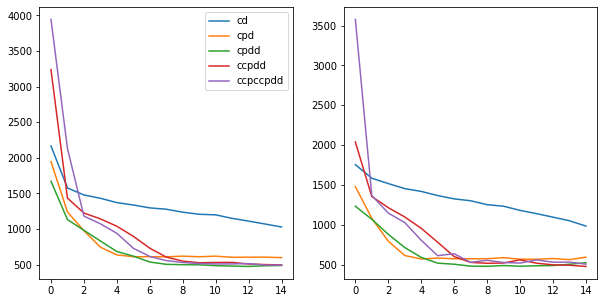

In [65]:
# Plot histories for different models
fig, ax = plt.subplots(1,2,figsize=(10,5))
for name in hh:
    ax[0].plot(hh[name].history['loss'], label=name)
    ax[1].plot(hh[name].history['val_loss'])
    
ax[0].legend()
plt.show()

# Regularization

132.46054077148438 278.4955749511719
Model: "sequential_84"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_154 (Conv2D)          (None, 23, 23, 5)         95        
_________________________________________________________________
conv2d_155 (Conv2D)          (None, 21, 21, 5)         230       
_________________________________________________________________
max_pooling2d_84 (MaxPooling (None, 10, 10, 5)         0         
_________________________________________________________________
conv2d_156 (Conv2D)          (None, 8, 8, 10)          460       
_________________________________________________________________
conv2d_157 (Conv2D)          (None, 6, 6, 10)          910       
_________________________________________________________________
max_pooling2d_85 (MaxPooling (None, 3, 3, 10)          0         
_________________________________________________________________
flatten_84 (Flat

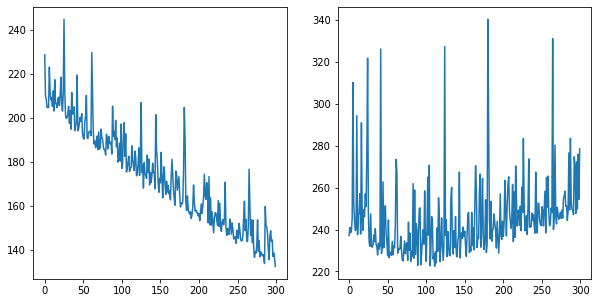

In [74]:
# Train for many epochs and check history
# The history shows that the model was overfitted
# At some point val_loss stoped decreasing
epochs = 300
h1 = compile_fit(mm['ccpccpdd'], epochs=epochs)

fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(h1.history['loss'], label='ccpccpdd')
ax[1].plot(h1.history['val_loss'])
plt.show()

In [75]:
# Make a model with the same arciteture but add regularization options

mm['ccpccpddr'] = Sequential()
# Normalize input data batch-by-batch
mm['ccpccpddr'].add(BatchNormalization(input_shape=x.shape[1:]))
mm['ccpccpddr'].add(Conv2D(5, 3, activation='relu'))
mm['ccpccpddr'].add(Conv2D(5, 3, activation='relu'))
mm['ccpccpddr'].add(MaxPooling2D(2, 2))
mm['ccpccpddr'].add(Conv2D(10, 3, activation='relu'))
mm['ccpccpddr'].add(Conv2D(10, 3, activation='relu'))
mm['ccpccpddr'].add(MaxPooling2D(2, 2))
mm['ccpccpddr'].add(Flatten())

# Randomly remove 10% neurons on every epoch
mm['ccpccpddr'].add(Dropout(0.1))

# Apply L2-regularization
mm['ccpccpddr'].add(Dense(10, kernel_regularizer=l2(0.01)))
mm['ccpccpddr'].add(Dense(1, kernel_initializer='random_normal'))

h2 = compile_fit(mm['ccpccpddr'], epochs=epochs)

260.90203857421875 276.0235900878906
Model: "sequential_86"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_4 (Batch (None, 25, 25, 2)         8         
_________________________________________________________________
conv2d_162 (Conv2D)          (None, 23, 23, 5)         95        
_________________________________________________________________
conv2d_163 (Conv2D)          (None, 21, 21, 5)         230       
_________________________________________________________________
max_pooling2d_88 (MaxPooling (None, 10, 10, 5)         0         
_________________________________________________________________
conv2d_164 (Conv2D)          (None, 8, 8, 10)          460       
_________________________________________________________________
conv2d_165 (Conv2D)          (None, 6, 6, 10)          910       
_________________________________________________________________
max_pooling2d_89

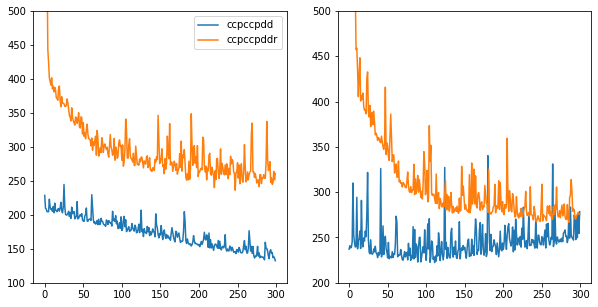

In [77]:
# Plot histories of the original and regularized models
# The regularized model has higher loss but has not been overfitted
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(h1.history['loss'], label='ccpccpdd')
ax[0].plot(h2.history['loss'], label='ccpccpddr')
ax[1].plot(h1.history['val_loss'])
ax[1].plot(h2.history['val_loss'])
ax[0].legend()
ax[0].set_ylim([100, 500])
ax[1].set_ylim([200, 500])
plt.show()

# Automatic selection of configuration

In [81]:
# ================================
# How functional API works:
# input = input_layer()
# x = layer1(*layer_params)(input)
# x = layer2(*layer_params)(x)
# x = layer3(*layer_params)(x)
# output = layer4(*layer_params)(x)
# model = Model(input, output)
# ================================

# Define a GENERIC structure of an image regressor using functional API
input_node = ak.ImageInput()
out_node = ak.Normalization()(input_node)
out_node = ak.ConvBlock()(out_node)
out_node = ak.DenseBlock()(out_node)
output_node = ak.RegressionHead()(out_node)

# Also specify how many trials shoul be run for finding a best arcitecture
reg = ak.AutoModel(
    inputs=input_node,
    outputs=output_node, 
    overwrite=True, 
    max_trials=5,
    project_name='reg',
    directory='ak_model',
)

In [82]:
# Run fitting of parameters and hyper-parameters
reg.fit(x, y, validation_split=0.2, epochs=10, batch_size=100)

Trial 5 Complete [00h 01m 02s]
val_loss: 360.0195007324219

Best val_loss So Far: 360.0195007324219
Total elapsed time: 00h 03m 30s
INFO:tensorflow:Oracle triggered exit
Epoch 1/10
23/23 [==============================] - 6s 247ms/step - loss: 1965.2461 - mean_squared_error: 1965.2461
Epoch 2/10
23/23 [==============================] - 6s 246ms/step - loss: 655.2894 - mean_squared_error: 655.2894
Epoch 3/10
23/23 [==============================] - 6s 248ms/step - loss: 514.0733 - mean_squared_error: 514.0733
Epoch 4/10
23/23 [==============================] - 6s 248ms/step - loss: 468.4062 - mean_squared_error: 468.4062
Epoch 5/10
23/23 [==============================] - 6s 246ms/step - loss: 452.5907 - mean_squared_error: 452.5907
Epoch 6/10
23/23 [==============================] - 6s 249ms/step - loss: 418.6010 - mean_squared_error: 418.6010
Epoch 7/10
23/23 [==============================] - 6s 248ms/step - loss: 390.2617 - mean_squared_error: 390.2617
Epoch 8/10
23/23 [============

In [84]:
# Show the automatic model
model = reg.export_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 25, 25, 2)]       0         
_________________________________________________________________
cast_to_float32 (CastToFloat (None, 25, 25, 2)         0         
_________________________________________________________________
normalization (Normalization (None, 25, 25, 2)         5         
_________________________________________________________________
conv2d (Conv2D)              (None, 23, 23, 32)        608       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 19, 19, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 17, 17, 32)        9248  

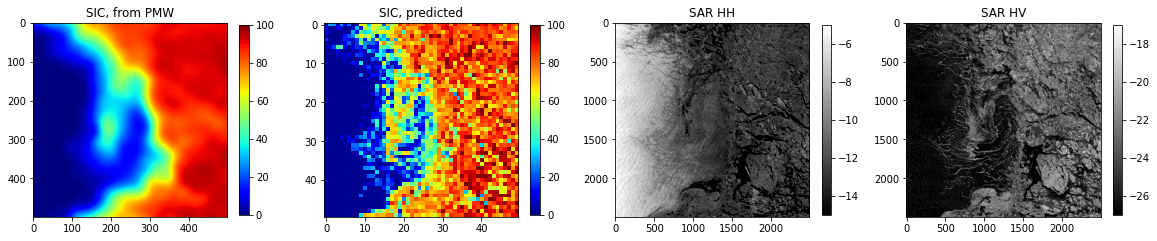

In [86]:
x_all = np.stack([hvr, hhr], axis=3)
y_all_ak = model.predict(x_all)
y_all_ak.shape = hv.shape[:2]

fig, ax = plt.subplots(1,4, figsize=(20,5))
img0 = ax[0].imshow(sic, clim=[0,100], cmap='jet')
ax[0].set_title('SIC, from PMW')
img1 = ax[1].imshow(y_all_ak, clim=[0,100], cmap='jet')
ax[1].set_title('SIC, predicted')
img2 = ax[2].imshow(img_hh.astype(float), clim=[-15, -5], cmap='gray')
ax[2].set_title('SAR HH')
img3 = ax[3].imshow(img_hv.astype(float), clim=[-27, -17], cmap='gray')
ax[3].set_title('SAR HV')

for img, a in zip([img0, img1, img2, img3], ax):
  plt.colorbar(img, ax=a, shrink=0.7)

plt.show()